In [1]:
%%sh
pip install openpyxl --quiet 
pip install lifelines --quiet
pip install scikit-learn --quiet
pip install seaborn --quiet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

In [3]:
# weird bug in XLSX loading creates annoying warnings, let's turn those off here
import warnings
warnings.simplefilter("ignore")

In [4]:
# patient survival and neoantigen prediction: 
#     A neoantigen fitness model predicts tumour response to checkpoint blockade immunotherapy 
#     https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6137806/
!ls ../data/nature*.xlsx

../data/nature24473_MOESM4_neoantigens.xlsx
../data/nature24473_MOESM5_survival.xlsx


In [5]:
# Luksza 2017 uses three cohorts of checkpoint trial data:
# - Snyder 2014
# - Van Allen 2015
# - Rizvi 2015
cohort_names = [
    "VanAllen",
    "Snyder",
    "Rizvi",
]

In [6]:
# load Luksza 2017 neoantigen data
# ...but we're not using it yet...

neoag_dataframes = []
for s in cohort_names:
    print("Loading neoantigens data for %s..." % (s,))
    df = pd.read_excel("../data/nature24473_MOESM4_neoantigens.xlsx", sheet_name=s + " et al.")
    df["Cohort"] = s
    neoag_dataframes.append(df)
    
df_neoag = pd.concat(neoag_dataframes);
df_neoag


Loading neoantigens data for VanAllen...
Loading neoantigens data for Snyder...
Loading neoantigens data for Rizvi...


,ID,MUTATION_ID,Sample,WT.Peptide,MT.Peptide,MT.Allele,WT.Score,MT.Score,HLA,Cohort
0,1,1_1563747_C_T_Pat02,Pat02,NHREVAQIL,NYREVAQIL,C0702,701,70,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
1,2,1_17087582_G_A_Pat02,Pat02,SPSNDFQVL,SPLNDFQVL,B0801,739,202,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
2,3,1_17087582_G_A_Pat02,Pat02,SPSNDFQVL,SPLNDFQVL,B0702,32,37,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
3,4,1_21806573_A_G_Pat02,Pat02,LLDEKEPEV,LLDEKGPEV,A0201,8,9,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
4,5,1_46073697_C_T_Pat02,Pat02,KPGQEAPVL,KPGQEASVL,B0702,90,31,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
...,...,...,...,...,...,...,...,...,...,...
4943,4944,8_113697930_C_A_ZA6965,ZA6965,CLSNFTAPM,CLSNFTAPI,A3201,1850,71,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4944,4945,X_68749680_T_A_ZA6965,ZA6965,RLCVLVLML,RLSVLVLML,A0201,419,172,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4945,4946,X_68749680_T_A_ZA6965,ZA6965,RLCVLVLML,RLSVLVLML,A3201,516,314,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4946,4947,X_68749680_T_A_ZA6965,ZA6965,SRIRLCVLV,SRIRLSVLV,C0602,751,146,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi


In [7]:
# load Luksza 2017 survival data

survival_dataframes = []
for s in cohort_names:
    print("Loading survival data for %s..." % (s,))
    df = pd.read_excel("../data/nature24473_MOESM5_survival.xlsx", sheet_name="Survival %s et al." % s)
    # convert 0/1 to False/True
    df["Status"] = df["Status"].astype(bool)
    df["Cohort"] = s
    survival_dataframes.append(df)
    
df_survival = pd.concat(survival_dataframes)
df_survival


Loading survival data for VanAllen...
Loading survival data for Snyder...
Loading survival data for Rizvi...


,Sample,Months,Status,Cohort
0,Pat02,53.654736,False,VanAllen
1,Pat03,3.287668,True,VanAllen
2,Pat04,32.449280,False,VanAllen
3,Pat06,5.293145,True,VanAllen
4,Pat08,4.602735,True,VanAllen
...,...,...,...,...
29,GR0134,21.900000,False,Rizvi
30,VA1330,23.400000,True,Rizvi
31,NI9507,27.900000,False,Rizvi
32,AU5884,2.400000,True,Rizvi


In [8]:
# let's threshold the survival times into binary labels for classification

df_survival["survived_1yr"] = df_survival.Months >= 12
df_survival["survived_2yr"] = df_survival.Months >= 24
df_survival["survived_3yr"] = df_survival.Months >= 36

# also, let's note when we know if a patient got to the thresholded time 
# by either surviving that long or dying previously
df_survival["known_at_1yr"] = df_survival.survived_1yr | df_survival.Status
df_survival["known_at_2yr"] = df_survival.survived_2yr | df_survival.Status
df_survival["known_at_3yr"] = df_survival.survived_3yr | df_survival.Status

df_survival

,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr
0,Pat02,53.654736,False,VanAllen,True,True,True,True,True,True
1,Pat03,3.287668,True,VanAllen,False,False,False,True,True,True
2,Pat04,32.449280,False,VanAllen,True,True,False,True,True,False
3,Pat06,5.293145,True,VanAllen,False,False,False,True,True,True
4,Pat08,4.602735,True,VanAllen,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
29,GR0134,21.900000,False,Rizvi,True,False,False,True,False,False
30,VA1330,23.400000,True,Rizvi,True,False,False,True,True,True
31,NI9507,27.900000,False,Rizvi,True,True,False,True,True,False
32,AU5884,2.400000,True,Rizvi,False,False,False,True,True,True


In [9]:
print("Fraction of patients with 1yr survival (or earlier censoring): %0.2f" % (df_survival.survived_1yr.mean(),))
print("Fraction of patients with 2yr survival (or earlier censoring): %0.2f" % (df_survival.survived_2yr.mean(),))
print("Fraction of patients with 3yr survival (or earlier censoring): %0.2f" % (df_survival.survived_3yr.mean(),))

print("---")
print("Fraction of patients with known 1yr outcome: %0.2f" % (df_survival.known_at_1yr.mean(),))
print("Fraction of patients with known 2yr outcome: %0.2f" % (df_survival.known_at_2yr.mean(),))
print("Fraction of patients with known 3yr outcome: %0.2f" % (df_survival.known_at_3yr.mean(),))


Fraction of patients with 1yr survival (or earlier censoring): 0.57
Fraction of patients with 2yr survival (or earlier censoring): 0.38
Fraction of patients with 3yr survival (or earlier censoring): 0.15
---
Fraction of patients with known 1yr outcome: 1.00
Fraction of patients with known 2yr outcome: 0.94
Fraction of patients with known 3yr outcome: 0.79


p-value = 7.667641442433392e-60


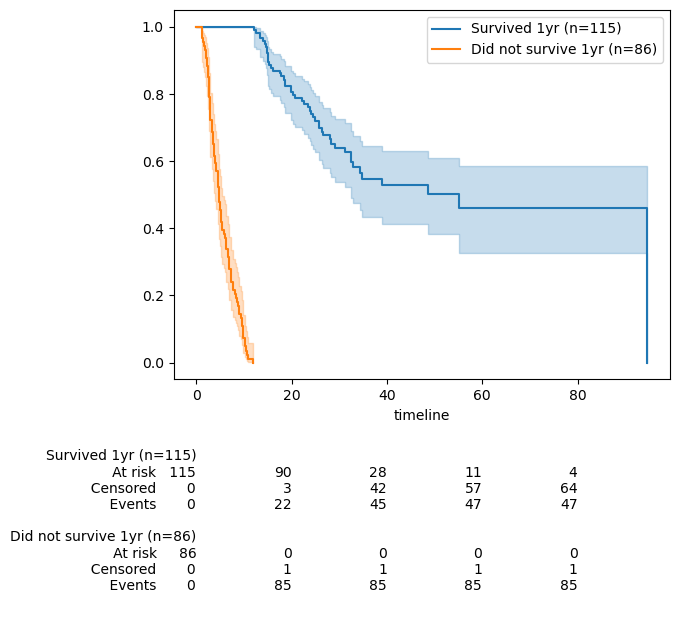

In [10]:
# is 1yr binary survival threshold a good basis for splitting the survival curves?

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts


ax = plt.subplot(111)

# plot the 1yr survivors
df_yes = df_survival[df_survival.survived_1yr]
kmf_yes = KaplanMeierFitter()
kmf_yes.fit(df_yes.Months, 
        event_observed=df_yes.Status, 
        label="Survived 1yr (n=%d)" % len(df_yes))  
kmf_yes.plot_survival_function(ax=ax)

# plot the 1yr non-survivors
df_no = df_survival[~df_survival.survived_1yr]
kmf_no = KaplanMeierFitter()
kmf_no.fit(df_no.Months, 
        event_observed=df_no.Status, 
        label="Did not survive 1yr (n=%d)" % len(df_no))
kmf_no.plot_survival_function(ax=ax)
add_at_risk_counts(kmf_yes, kmf_no)


from lifelines.statistics import logrank_test
hypothesis_test_result = logrank_test(df_yes.Months, df_no.Months, event_observed_A=df_yes.Status, event_observed_B=df_no.Status)
print("p-value = %s" % (hypothesis_test_result.p_value,))

In [11]:
# LET'S GENERATE SOME FEATURES!


# given a column of a dataframe, generate all counts of combinations up to length k
from tqdm import tqdm

def generate_features(column, k=1):
    assert k >= 1
    unique_values = sorted(set("".join(column)))
    print("Unique tokens in %s: %s" % (column.name, unique_values))
    counts = {}

    print("Generating singleton count features...")
    for c in tqdm(unique_values):
        counts[c] = np.array([p.count(c) for p in column])
        
    for i in range(2, k + 1):
        higher_order_counts = {}
        print("Generating counts of %d characters" % (i,))
   
        for old_feature_name, old_feature_values in tqdm(list(counts.items())):
            for c in unique_values:
                if c not in old_feature_name:
                    new_name = "".join(sorted(old_feature_name + c))
                    if new_name not in higher_order_counts:
                        higher_order_counts[new_name] = old_feature_values + counts[c]
        counts.update(higher_order_counts)
    print("Total number of generated features = %d" % (len(counts),))
    return pd.DataFrame(counts, index=column.index);

In [12]:
df_survival.Sample

0      Pat02
1      Pat03
2      Pat04
3      Pat06
4      Pat08
       ...  
29    GR0134
30    VA1330
31    NI9507
32    AU5884
33    VA7859
Name: Sample, Length: 201, dtype: object

In [13]:
# generate raw features to use in a classifier from the PATIENT/SAMPLE IDs (!!)
df_new_features = generate_features(df_survival.Sample, k=1)
df_new_features

Unique tokens in Sample: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 't']
Generating singleton count features...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 32147.10it/s]

Total number of generated features = 36


,0,1,2,3,4,5,6,7,8,9,...,R,S,T,U,V,W,Y,Z,a,t
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,1,1,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
30,1,1,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
31,1,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
32,0,0,0,0,1,1,0,0,2,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
feature_names = sorted(df_new_features.columns);
feature_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'Z',
 'a',
 't']

In [15]:
# get the correlation of every feature with the target label
correlations = df_new_features.corrwith(df_survival.survived_1yr);

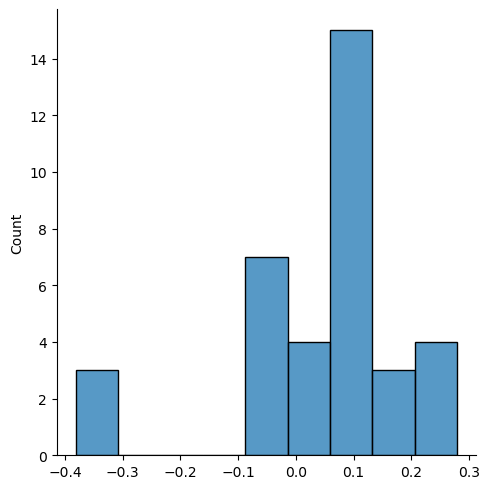

In [16]:
# plot the distribution of random correlations
sns.displot(correlations)

In [17]:
# which features are most strongly correlated?
correlations.sort_values()

t   -0.380824
a   -0.380824
P   -0.321915
T   -0.081768
1   -0.070577
U   -0.059412
O   -0.059412
M   -0.059412
4   -0.019117
G   -0.014617
N   -0.004633
8    0.016540
7    0.030909
5    0.044481
Y    0.061148
E    0.061148
K    0.061148
F    0.061148
J    0.061148
W    0.061148
2    0.061624
3    0.069802
H    0.086694
Z    0.086694
V    0.086694
6    0.095060
B    0.106446
I    0.106446
A    0.119654
0    0.177919
R    0.190842
L    0.197114
D    0.206546
9    0.207247
S    0.264982
C    0.279410
dtype: float64

In [18]:
# which patients get picked up by this feature?

#  "CR" in the sample name!
df_survival[df_survival.Sample.str.contains("C")]

,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr
0,CR0095,67.89041,False,Snyder,True,True,True,True,True,True
1,CR04885,25.60000,False,Snyder,True,True,False,True,True,False
2,CR06670,44.40000,False,Snyder,True,True,True,True,True,True
3,CR1509,53.85205,False,Snyder,True,True,True,True,True,True
4,CR22640,51.20000,False,Snyder,True,True,True,True,True,True
5,CR3665,31.85753,False,Snyder,True,True,False,True,True,False
6,CR4880,64.30685,False,Snyder,True,True,True,True,True,True
7,CR6126,22.80000,False,Snyder,True,False,False,True,False,False
8,CR6161,31.30000,False,Snyder,True,True,False,True,True,False
9,CR7623,64.80000,False,Snyder,True,True,True,True,True,True


In [19]:
# what about features with "t" in them?


has_t = df_survival.Sample.str.contains("t")


df_survival[has_t]

,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr
0,Pat02,53.654736,False,VanAllen,True,True,True,True,True,True
1,Pat03,3.287668,True,VanAllen,False,False,False,True,True,True
2,Pat04,32.449280,False,VanAllen,True,True,False,True,True,False
3,Pat06,5.293145,True,VanAllen,False,False,False,True,True,True
4,Pat08,4.602735,True,VanAllen,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
98,Pat86,9.632866,True,VanAllen,False,False,False,True,True,True
99,Pat88,32.515033,False,VanAllen,True,True,False,True,True,False
100,Pat90,33.041060,False,VanAllen,True,True,False,True,True,False
101,Pat92,4.043831,True,VanAllen,False,False,False,True,True,True


In [20]:
# picks out a specific cohort: Van Allen 2015
df_survival[has_t].Cohort.value_counts()


VanAllen    103
Name: Cohort, dtype: int64

In [21]:
# remember, the Van Allen cohort had the lowest overall survival since it's an unbiased 
# sample of aCTLA-4 for metastatic melanoma...
# By comparison, Snyder was selected for long-term survival and Rizvi was aPD1 for lung cancer
df_survival[has_t].Months.mean() / df_survival[~has_t].Months.mean()

0.508999925900345

In [22]:
X = df_new_features.values
y = df_survival.survived_1yr.values
print("X.shape = %s" % (X.shape,))
print("y.shape = %s" % (y.shape))

X.shape = (201, 36)
y.shape = 201


In [23]:
# run a forward feature selector to pick the best feature in the whole dataset

def select_features(X, y, n_features_to_select=1):
    """
    Hand-rolled forward feature selector
    """
    selected = []
    # ignore any features which are identical for all rows
    excluded = {
        i for i in range(X.shape[1])
        if (X[0, i] == X[1:, i]).all()
    }
    X_subset = X.copy()
    y_subset = y.copy()
    n_features_to_select = min(n_features_to_select, X.shape[1])
    while len(selected) < n_features_to_select:
        print("Selecting feature #%d, %d/%d rows active" % (
            len(selected) + 1,
            len(X_subset),
            len(X),
        ))
        best_score = 0
        best_idx = None
 
        for i in range(X.shape[1]):
            if i in selected or i in excluded:
                continue
            col = X_subset[:, i]
            corr = abs(np.corrcoef(col, y_subset)[0, 1])
         
            if corr > best_score:
                best_idx = i
                best_score = corr
                
        if best_score == 0:
            if len(X_subset) == len(X):
                break
            else:
                X_subset = X.copy()
                y_subset= y.copy()
                continue
                
        selected.append(best_idx)
        print("--> selected feature #%d (corr = %0.2f on %d/%d samples)" % (
            best_idx,
            best_score,
            len(X_subset),
            len(X),
            
        ))
        # exclude any features which are identical to one we select
        redundant = {
            i for i in range(X.shape[1])
            if (X[:, i] == X[:, best_idx]).all() and i != best_idx
        }
        excluded.update(redundant)
        print("--> excluding redundant features: %s" % (redundant,))
        best_col = X_subset[:, best_idx]
        ts = {np.percentile(best_col, 25), np.percentile(best_col, 50), np.percentile(best_col, 75)}
        cmp_fns = [np.less, np.less_equal, np.greater, np.greater_equal]
        best_acc = 0
        
        for t in ts:
            for cmp_fn in cmp_fns:
                mask = cmp_fn(col, t)
                correct = (mask == y_subset)
                acc = correct.mean()
                if acc > best_acc:
                    best_acc = acc
                    best_correct = correct
        print("--> best threshold accuracy = %0.2f%% on %d/%d samples" % (
            best_acc * 100,
            len(X_subset),
            len(X)
        ))
        X_subset = X_subset[~best_correct]
        y_subset = y_subset[~best_correct]
        if len(X_subset) == 0 or (y_subset[0] == y_subset[1:]).all():
            X_subset = X.copy()
            y_subset = y.copy()
    return list(selected)
        

In [24]:
selected_feature_indices = select_features(X, y, 1)
selected_feature_names = [feature_names[i] for i in selected_feature_indices]
selected_feature_names

Selecting feature #1, 201/201 rows active
--> selected feature #34 (corr = 0.38 on 201/201 samples)
--> excluding redundant features: {35}
--> best threshold accuracy = 68.66% on 201/201 samples


['a']

In [25]:
# NOW, split the data randomly

indices = np.arange(len(X))
np.random.shuffle(indices)
train_indices = indices[:len(X) // 2]
test_indices = indices[len(X) // 2:]

X_train = X[train_indices, :]
X_test = X[test_indices, :]

y_train = y[train_indices]
y_test = y[test_indices]


print("%dx%d training samples (%0.2f%% survival), %dx%d test samples (%0.2f%% survival)" % (
    len(X_train),
    X_train.shape[1],
    y_train.mean() * 100,
    len(X_test),
    X_test.shape[1],
    y_test.mean() * 100
))



100x36 training samples (58.00% survival), 101x36 test samples (56.44% survival)


In [26]:
# let's fit a model on just the training set
lr = sklearn.linear_model.LogisticRegression()
lr.fit(X_train[:, selected_feature_indices], y_train)

print("coef = ", lr.coef_)


AttributeError: module 'sklearn' has no attribute 'linear_model'

In [ ]:
# what do the predictions look like?

y_train_pred = lr.predict(X_train[:, selected_feature_indices])
y_test_pred = lr.predict(X_test[:, selected_feature_indices])
print("y_train=%s" % (y_train,))
print("y_train_pred=%s" % (y_train_pred,))

print("y_test=%s" % (y_test,))
print("y_test_pred=%s" % (y_test_pred,))




In [ ]:
# are these predictions any good?

print("Accuracy = %0.2f%%" % (100 * np.mean(y_test_pred == y_test)))

In [ ]:
# now let's apply this predictor to split survival curves

ax = plt.subplot(111)

df_test = df_survival.iloc[test_indices]
df_yes = df_test[y_test_pred]
df_no = df_test[~y_test_pred]

kmf_yes = KaplanMeierFitter()
kmf_yes.fit(df_yes.Months, 
        event_observed=df_yes.Status, 
        label="Predicted to survive 1yr (n=%d)" % len(df_yes))  
kmf_yes.plot_survival_function(ax=ax)

# plot the 1yr non-survivors
kmf_no = KaplanMeierFitter()
kmf_no.fit(df_no.Months, 
        event_observed=df_no.Status, 
        label="Not predicted to survive 1yr (n=%d)" % len(df_no))
kmf_no.plot_survival_function(ax=ax)
add_at_risk_counts(kmf_yes, kmf_no)


from lifelines.statistics import logrank_test
hypothesis_test_result = logrank_test(df_yes.Months, df_no.Months, event_observed_A=df_yes.Status, event_observed_B=df_no.Status)
print("p-value = %s" % (hypothesis_test_result.p_value,))

In [ ]:
# what if we increase the number of possible features?


# let's look at counts of three different letters
df_new_features_3 = generate_features(df_survival.Sample, k=3);
df_new_features_3


In [ ]:
# get the correlation of every feature with the target label
correlations_3 = df_new_features_3.corrwith(df_survival.survived_1yr);
correlations_3

In [ ]:
# plot the distribution of random correlations
sns.displot(correlations_3)